In [43]:
import pandas as pd
import numpy as np
import tensorflow as tf
import xgboost
import time
import os
import matplotlib.pyplot as plt
import itertools
import shutil

from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn import metrics

import warnings
warnings.filterwarnings(action='ignore')
print(os.getcwd())

G:\My Drive\Veld_Code\Python_Code\20210712_KAIST_RNN\20211223_Refrac_v3_Update


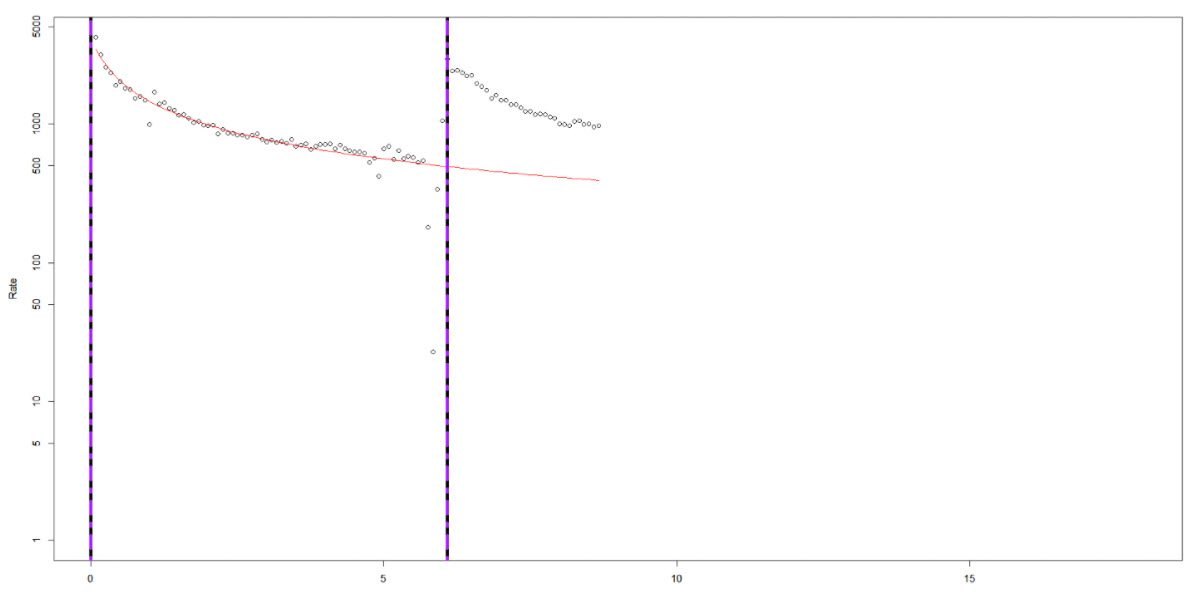

In [44]:
'''
this is a RNN model example
input is the time series data of gas production each month for each well
the goal is to find the time when the refrac occur
the refrac (see example above) is defined as a jump of gas rate with
another spike and then start to decline again
I labeled 4000+ wells for refrac, and I use RNN to build the model
the model is then to bee deployed to predict over 200,000+ wells across the United Statss
based on our assumption, we only detect up to two refrac events in this study
'''

'\nthis is a RNN model example\ninput is the time series data of gas production each month for each well\nthe goal is to find the time when the refrac occur\nthe refrac (see example above) is defined as a jump of gas rate with\nanother spike and then start to decline again\nI labeled 4000+ wells for refrac, and I use RNN to build the model\nthe model is then to bee deployed to predict over 200,000+ wells across the United Statss\nbased on our assumption, we only detect up to two refrac events in this study\n'

In [45]:
# This is the folder to save all the training results
# All the epoch fit data are saved here
# this should only run once for the training
# once training is finished, do not run this again
# otherwise it will remove this folder entirely (with rmtree command)

checkpoint_dir = './training_checkpoints'
# if os.path.isdir(checkpoint_dir):
#     shutil.rmtree(checkpoint_dir)
target = 'Refrac' # 'Refrac' / 'Convex' / 'BoundaryInterference' / 'MechanicalFailure' / 'SurfaceConstraint'
np.random.seed(0)

### Load data

In [46]:

# import the historical gas production data (monthly time series)
hist_df  = pd.read_csv('hist_df_manual_merge_v4.csv', encoding='latin-1')

# import a header data with 4000 wells where I manually labeled which month
# the refrac event would occur 
label_df = pd.read_csv('label_df_manual_merge_v4.csv')

# Function 0: make sure the header file and monthly production file is 1:1 match 
label_df = label_df[label_df['API.Number'].isin(hist_df['API'])]
hist_df = hist_df[hist_df['API'].isin(label_df['API.Number'])]

# Sort both the headers and monthly production data
label_df = label_df.sort_values(['API.Number'], ascending = True)
hist_df['ReportDate'] = pd.to_datetime(hist_df['ReportDate'])
hist_df = hist_df.sort_values(["API", "ReportDate"], ascending = (True, True)) 

hist_df['ReportDate'] = pd.to_datetime(hist_df['ReportDate'])
hist_df.drop_duplicates(subset=['API','ReportDate'],keep='last',inplace=True)

# reset index
hist_df = hist_df.reset_index(drop=True)
label_df = label_df.reset_index(drop=True)

print(hist_df.shape)
print(hist_df['API'].nunique())
print(label_df.shape)
print(label_df['API.Number'].nunique())

(566968, 4)
4769
(4769, 6)
4769


In [47]:
hist_df.head()

,API,ReportDate,ActualProdGas,Instance
0,17013220610000,2011-03-01,6719.77,1
1,17013220610000,2011-04-01,7235.45,2
2,17013220610000,2011-05-01,6710.80,3
3,17013220610000,2011-06-01,7461.45,4
4,17013220610000,2011-07-01,7584.30,5


In [48]:
label_df.head()

,API.Number,TotalMonthsProdHistory,Event_01_Name,Event_01_Start,Event_02_Name,Event_02_Start
0,17013220610000,114,Refrac,82,-1,-1
1,17013221160000,108,Refrac,58,-1,-1
2,17015237940000,149,Refrac,134,-1,-1
3,17015243930000,152,Refrac,99,-1,-1
4,17015246500000,121,Refrac,100,-1,-1


### Preprocessing

In [49]:

# the maximum months of all the wells 
max_len = label_df['TotalMonthsProdHistory'].max()
max_len

215

In [50]:
# assgin lists to fill in the loop
inputs, labels, length, apis  = [], [], [], []



with tqdm(total=label_df['API.Number'].nunique()) as pbar:
    
    # loop through the API
    for api in label_df['API.Number'].unique():
        
        # this_df is the current loop of QMM file
        this_df = hist_df[hist_df['API'] == api]   

        # the labels will be a length of max total months of history

        
        event_name = np.asarray(label_df[label_df['API.Number'] == api]['Event_01_Name'])[0].replace(' ', '')
        event_name2 = np.asarray(label_df[label_df['API.Number'] == api]['Event_02_Name'])[0].replace(' ', '')
        start_time1 = float(label_df[label_df['API.Number'] == api]['Event_01_Start'])
        start_time2 = float(label_df[label_df['API.Number'] == api]['Event_02_Start'])

        
        # Gas is normalized as (x-mean) / std, which is the Zscore of the gas
        # this will result in a standardized gas array
        # also expand the dimension of this 1-D array into a 2-D array 
        
        if event_name == target or event_name2 == target:
            if start_time1 != -1 or start_time2 != -1:
                
                
                # Gas rate is mormalized as (x-mean) / std, which is the Zscore of the gas
                # this will result in a standardized gas array
                # also expand the dimension of this 1-D array into a 2-D array 
                Gas    = (np.expand_dims(np.asarray(this_df['ActualProdGas']), axis=1) - this_df[
                    'ActualProdGas'].mean()) / this_df['ActualProdGas'].std()
                
                
                # Features is the normlaized gas rate
                feat = np.concatenate([Gas], axis=1)
                
                
                # length of the 2-D matrix, or total number of wells
                length.append(feat.shape[0])
                
                # this is to give pad the input to be exactly match the lenth of the max number of months       
                inputs.append(np.pad(feat, ((0, max_len-len(feat)), (0,0)), constant_values=0))
                
                # just append the API list 
                apis.append(api)
                
                # initialized the label array with all 0 [0,0,0,0.......,0]
                # the length of this list if the max monts of production history    
                label = np.zeros(max_len)
                
                # assign the event from the labeling to 1 in this array 
                # it will be like [0,0,0,1,0,0.......,0]
                # if refrac event = 4                
                if event_name == target and start_time1 != -1:
                    label[int(start_time1)] = 1
                if event_name2 == target and start_time2 != -1:
                    label[int(start_time2)] = 1
                
                
                # append the list of label to a larger list 
                # this larger list is a 2-D list that contain all label array                 
                labels.append(label)
                
        pbar.update(1)
        
inputs = np.asarray(inputs)
labels = np.asarray(labels)
length = np.asarray(length)
apis = np.asarray(apis)

100%|█████████████████████████████████████████████████████████████████████████████| 4769/4769 [00:10<00:00, 438.38it/s]


In [51]:
inputs

array([[[ 2.5571751 ],
        [ 2.80631809],
        [ 2.55284138],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 2.52090917],
        [ 1.91288867],
        [ 2.70801851],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.06832714],
        [ 0.77415124],
        [ 7.00214795],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       ...,

       [[-0.30930381],
        [ 4.42292131],
        [ 3.34290519],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.76040253],
        [ 4.78578735],
        [ 3.83746525],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 3.65145664],
        [ 3.0412893 ],
        [ 2.36522458],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]]])

In [52]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
length

array([114, 108, 149, ...,  79,  82,  59])

In [54]:
inputs.shape

(4769, 215, 1)

### Split the data to Train, Valid and Test (80%, 10%, 10%)
Training : validation : test = 80% : 10%: 10%

In [55]:

# this should be the total number of wells
input_len = len(labels)

# index the wells and shuffle them 
ind = np.arange(0, input_len)
np.random.shuffle(ind)

# shuffle input based on the random shuffled indexs 
inputs = inputs[ind, :, :]
labels = labels[ind, :]
length = length[ind]
apis   = apis[ind]

# Training set
# train set is 80% of the input data
train_inputs = inputs[:int(0.8*input_len)]
train_labels = labels[:int(0.8*input_len)]
train_length = length[:int(0.8*input_len)]
train_apis   = apis[:int(0.8*input_len)]

# Validation set
# validation set is 10% of the input data
valid_inputs = inputs[int(0.8*input_len):int(0.9*input_len)]
valid_labels = labels[int(0.8*input_len):int(0.9*input_len)]
valid_length = length[int(0.8*input_len):int(0.9*input_len)]
valid_apis   = apis[int(0.8*input_len):int(0.9*input_len)]

# Test set
# test set is 10% of the input data
test_inputs = inputs[int(0.9*input_len):]
test_labels = labels[int(0.9*input_len):]
test_length = length[int(0.9*input_len):]
test_apis   = apis[int(0.9*input_len):]

In [56]:
len(train_inputs)

3815

### RNN, Build the Model Framework

In [57]:
# function to setup the structure of the RNN model 
# here this model apply GRU (a simplifed solution similar to LSTM)

def GRU4REC(hidden_size):
    
    
    # input has 1 parameters (which is Gas Rate)
    inputs   = tf.keras.layers.Input(shape=(None, 1), name='inputs')
    
    # input length 
    length   = tf.keras.layers.Input(shape=1, name='length')

    # setup the Gated recurrent units 
    # hidden size = 128, and we use 0 or 1 in this case, so activation = sigmoid
    gru_cell = tf.keras.layers.GRUCell(units=hidden_size,
                                       reset_after=False,
                                       activation='sigmoid',
                                       recurrent_initializer='glorot_uniform',
                                       recurrent_activation='hard_sigmoid')
    
    # this is the 1-D Convoluted Neural Neteork layer right after the input
    feats = tf.keras.layers.Dense(units=128, activation='relu', name='rnn_inputs')(inputs)
    
    # assigned 1-D CNN model here
    # it has 128 neurons and 5 kernal (scan window size = 5)
    # activation function for this CNN is relu    
    feats=tf.keras.layers.Conv1D(
        128, 5, activation='relu', padding='SAME')(feats)
    
    # also tested LSTM
    # rnn_outputs, hidden, states = tf.keras.layers.LSTM(units=hidden_size,
    #                                         return_sequences=True,
    #                                         return_state=True)(feats)


    # here assigned Bidirectional RNN with GRU 
    # this is the layer after 1D-CNN
    rnn_outputs, states, _ = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(units=hidden_size,
                            return_sequences=True,
                            return_state=True))(feats)
    
    
    # dropout layer that drop 50% to avoid overfitting    
    outputs = tf.keras.layers.Dropout(rate=0.5)(rnn_outputs)

    # Last predict results after dropout 
    # Activatio fuction is sigmoid
    # this is where the bug was fixed
    # previously it was 
    # preds    = tf.keras.layers.Dense(units=1, activation='linear', dtype='float32', name='preds')(outputs)
    preds = tf.reshape(tf.keras.layers.Dense(units=1, activation='sigmoid')(outputs), [-1, max_len])

    # define the entire input and output of the model     
    model = tf.keras.Model(inputs=[inputs, length],
                           outputs={'preds': preds})

    return model

In [58]:
# Adam optimization function, which is sthochastic gradiend descendent (SGD)
# the alpha (learning rate) of this SGD is 0.0001, very small 
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


# the metrics are defiend as AUC (area under curve)
train_auc = tf.keras.metrics.AUC()
test_auc = tf.keras.metrics.AUC()

# batch size is 16
batch_size = 16

In [59]:
# set up the model using the function defined above
# here the hidden size is set to be 128

model = GRU4REC(128)
model.summary()
@tf.function

# define how the training process work step by step
# in the big function, this is called in the loop of each batch
# such as inputs[0:16], labels[0:16], length[0:16]
def train_step(inp, target, length):
    
    # this GradientTape command give more control in the gradient descent 
    with tf.GradientTape() as tape:
        
        # generate predictions y'
        predictions = model([inp, length]) #

        # here defined the loss function
        # loss function is defined as binary crossentropy
        # 503.08 is a random large number that add more weights to the imbalanced data
        loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(
                tf.reshape(target, [-1]),  tf.reshape(tf.cast(predictions['preds'], 'float64'), [-1])) * (tf.reshape(target, [-1]) * 503.08 + 0.5))

    # gradient calcualted using the loss functions
    grads = tape.gradient(loss, model.trainable_variables)
    
    # zip the gradient and variables of the model (gas)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # update the train AUC, this will be printed as the QC process
    train_auc.update_state(tf.reshape(target, [-1]), tf.reshape(predictions['preds'], [-1]))
    
    return loss



# this is the function for predicting the test or validation dataset
# input is still the batched input data
# return the prediction using the input data 

def infer_step(inp, target, length):
    with tf.GradientTape() as tape:
#         print(inp)
        predictions = model([inp, length]) #
    test_auc.update_state(tf.reshape(target, [-1]), tf.reshape(predictions['preds'], [-1]))
    return predictions['preds']

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
rnn_inputs (Dense)              (None, None, 128)    256         inputs[0][0]                     
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, None, 128)    82048       rnn_inputs[0][0]                 
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, None, 256),  198144      conv1d_3[0][0]                   
____________________________________________________________________________________________

In [60]:
# this function generate the batch during training 
# np.ceil return the ceiling of the float number
# for example np.ceil([-1,7, 0.2, 1.5]) returns ([-1,1,2])




# the batch is defined by total well number // batch size
def batch_gen(inputs, labels, length):
    
    
    # if batch size = 16
    # this max_len basically is the total number of wells / batch size
    # return how many batches in one epoch run
    # max_len is the number of batchs in each run with the assigned batch size 
    # this is wher the bug was fixed 
    # previously it was max_len = len(labels) // batch_size + 1
    max_len = int(np.ceil(len(labels) / batch_size))

    
    for i in range(max_len):
        yield inputs[batch_size*i:batch_size*(i+1)], labels[batch_size*i:batch_size*(i+1)], length[batch_size*i:batch_size*(i+1)]

### Below is the actual training process
### It take very long time to run
### Once finished, save the best epoch
### and do not touch this part again

In [61]:

# # start training process here
# EPOCHS = 100
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
# hidden = model.reset_states()

# # save best auc and best epoch in these parameter
# best_auc, best_epoch = 0, 0

# # start loop on epoch 0 to max epoch 
# for epoch in range(EPOCHS):
    
#     # timing the process
#     start = time.time()
  
#     # index and shuffle the training data    
#     ind = np.arange(len(train_labels))
#     np.random.shuffle(ind)

    
#     # shuffle the training data everytime of the loop
#     # this is to avoid overfitting 
#     epoch_inputs  = train_inputs[ind, :, :]
#     epoch_labels  = train_labels[ind, :]
#     epoch_length  = train_length[ind]
    
#     losses = []
    
#     # batch_gen: input of the input data, input label and length
#     # output each batch index, such as inputs[0:16], labels[0:16], length[0:16]
#     # for batch size = 16
#     # so loop start with the 0th batch (batch_n as the index)
#     # the 1st batch is input[17:32], labels[17:32], and length[17:32]
#     # for each batch, get the loss using train_step fuction 
#     for (batch_n, (inp, target, lens)) in enumerate(batch_gen(epoch_inputs, epoch_labels, epoch_length)):
#         loss = train_step(inp, target, lens)
#         losses.append(loss)

#     # use the infer function to get the prediction on validation dataset for each batch
#     # every time this function is called, test_auc is also updated        
#     for (val_batch_n, (inp, target, lens)) in enumerate(batch_gen(valid_inputs, valid_labels, valid_length)):
#         val_preds = infer_step(inp, target, lens)
        
#     # here the train auc is updated each time if we call the train_step 
#     # so each Epoch this will be updated
#     # this is basically tell you how good this train epoch accuracy is    
#     print("[*] Train AUC: {:.4f}".format(train_auc.result()))
    
#     # save model parameters every 2 epochs
#     if (epoch + 1) % 2 == 0:
        
#         # compare to see if this_auc is the best_auc 
#         this_auc = test_auc.result()
#         if this_auc > best_auc:
#             best_epoch = epoch
#             best_auc = this_auc
#         print("[*] Val AUC: {:.4f} | Best epoch: {}".format(this_auc, best_epoch))
#         model.save_weights(checkpoint_prefix.format(epoch=epoch))
       
#     # Early-stopping
#     if (epoch - best_epoch) > 50:
#         break

#     print ('[*] Epoch {} loss {:.4f}'.format(epoch+1, loss))
#     print ('[*]1 Time {:.4f}sec per epoch\n'.format(time.time() - start))
#     train_auc.reset_states()
#     test_auc.reset_states()


### Above is the all training process, once finished, saved and do not touch again
### Load the best model, below is to load the best model saved and deploy them for prediction

In [62]:
best_epoch = 65

In [63]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
model.load_weights(checkpoint_prefix.format(epoch=best_epoch))

###  Inference (Predict the 10% test data)

In [64]:
train_probas, test_probas = [], []

for (batch_n, (inp, target, lens)) in enumerate(batch_gen(train_inputs, train_labels, train_length)):
    proba = infer_step(inp, target, lens)
    train_probas.extend(proba.numpy())
    
train_probas = np.asarray(train_probas)

for (batch_n, (inp, target, lens)) in enumerate(batch_gen(test_inputs, test_labels, test_length)):
    proba = infer_step(inp, target, lens)
    test_probas.extend(proba.numpy())
    
test_probas = np.asarray(test_probas)

In [65]:
test_probas.shape

(477, 215)

### Performance on 10% test data
AUC (Area Under the Curve) performance for the each point

In [66]:
g_truth = np.asarray(test_labels.reshape([-1]))
predictions = np.asarray(test_probas.reshape([-1]))

fpr, tpr, thresholds = metrics.roc_curve(g_truth.astype(int), predictions, pos_label=1)
AUC = metrics.auc(fpr, tpr)
print("AUC is : {0:.2f}".format(AUC*100))

AUC is : 99.56


Predict the final results.
**For less sensitive results, set the threshold to a larger value.**

In [67]:

# this is to change the probability into event as integers

# this is to set the threshhold of probability
# if the probability is > 0.4, which will qualified as a event
# if we want this to be less sensative (less event), make this higher number


threshold = 0.5


# this is to initialize the list of ground truth and predictions
# in each loop, we will append the ground truth and predicted results as 
# string and append to this list
gts, preds = [], []
for i in range(test_probas.shape[0]):
    
    
    # initialize the ground truth string for each loop, such as "4,12", or "2"
    gt_str = ''
    
    # this is to record where the labels is 1
    for j in np.where(test_labels[i, :] > threshold)[0]:
        gt_str = gt_str + '{0:d},'.format(j)
        
    # append and forming the ground truth list
    gts.append(gt_str[:-1])
    
    # initialize the prediction string for each loop
    pred_str = ''
    
    # if the prediction is more than the threshhold 
    # assgined them as one event 
    for k in np.where(test_probas[i, :] > threshold)[0]:
        pred_str = pred_str + '{0:d},'.format(k)
    preds.append(pred_str[:-1])

gts = np.asarray(gts)
preds = np.asarray(preds)

In [68]:
results_df = pd.DataFrame({
    'API': test_apis,
    'Preds': preds.reshape([-1]),
    'Event_Start_Time': gts.reshape([-1])
})

results_df.to_csv('Refrac_Start_Time_Prediction_R2.csv'.format(target), index=False)
results_df

,API,Preds,Event_Start_Time
0,33025006530000,118,118
1,30015407560000,73,73
2,33009023300000,69,69
3,33025007540000,45,45
4,33061015800000,74,74
...,...,...,...
472,33025027310000,35,35
473,42251304190000,66,66
474,33061005040000,96,96
475,42121318000000,70,70


### Deploy the model to a new dataset

In [69]:
# try to get dataset in Applachian using the trained model 

df_header_test = pd.read_csv('df_header.csv')
df_QMM_test = pd.read_csv('df_QMM.csv')


# filter the headers to be less than the training set
df_header_test = df_header_test[df_header_test['TotalMonthsHistory'] <= label_df['TotalMonthsProdHistory'].max()]

df_QMM_test = df_QMM_test[df_QMM_test['API'].isin(df_header_test['API'])]
df_header_test = df_header_test[df_header_test['API'].isin(df_QMM_test['API'])]

df_header_test = df_header_test.sort_values(['API'], ascending = True)
df_QMM_test = df_QMM_test.sort_values(["API", "Instance"], ascending = (True, True)) 

df_header_test.reset_index(inplace=True,drop=True)
# df_header_test = df_header_test.drop(columns=['index'])

df_QMM_test.reset_index(inplace=True,drop=True)
# df_QMM_test = df_QMM_test.drop(columns=['index'])


print(df_header_test.shape)
print(df_header_test['API'].nunique())
print('*'*20)
print(df_QMM_test.shape)
print(df_QMM_test['API'].nunique())

(9513, 73)
9513
********************
(775438, 10)
9513


In [70]:
label_df['TotalMonthsProdHistory'].max()

215

In [71]:
# process the test data
# keep in mind that the test data do not have any labels_1
# only process the input data


# get the maximum production months
max_len = label_df['TotalMonthsProdHistory'].max()


# initialize empty list
inputs_1, labels_1, length_1, apis_1  = [], [], [], []


# set up the loading progress bar
with tqdm(total=df_header_test['API'].nunique()) as pbar:
    
    # loop all the unique API in the label table 
    for api in df_header_test['API'].unique():
                        
        # get the individual API QMM file        
        this_df = df_QMM_test[df_QMM_test['API'] == api]
        
        # just get the input for model predictions here.
        # no label needed
        Gas    = (np.expand_dims(np.asarray(this_df['ActualProdOil']), axis=1) -
                  this_df['ActualProdOil'].mean()) / this_df['ActualProdOil'].std()
        
        feat = np.concatenate([Gas], axis=1)
        length_1.append(feat.shape[0])
        inputs_1.append(np.pad(feat, ((0, max_len-len(feat)), (0,0)), constant_values=0))
        apis_1.append(api)
       
        # this is the dummy labels_1 just for completeness of the process
        # we do not need this for blind prediction case 
        label = np.zeros(max_len)
        labels_1.append(label)
            
        pbar.update(1)

        
# input is an array with equal length_1
inputs_1 = np.asarray(inputs_1)

# is an array with all 0
labels_1 = np.asarray(labels_1)

# the origional length_1 of all the wells
length_1 = np.asarray(length_1)

# all the API list
apis_1 = np.asarray(apis_1)

100%|█████████████████████████████████████████████████████████████████████████████| 9513/9513 [00:10<00:00, 905.85it/s]


In [72]:
print(len(inputs_1))
print(len(inputs_1[0]))

print(len(labels_1))
print(len(labels_1[0]))

print(len(length_1))
print(len(apis_1))


9513
215
9513
215
9513
9513


In [73]:
inputs_1.shape

(9513, 215, 1)

In [74]:
input_len_1 = len(apis_1)

# Test set
test_1_inputs = inputs_1
test_1_labels = labels_1
test_1_length = length_1
test_1_apis   = apis_1

In [75]:
print(len(test_1_inputs))
print(len(test_1_inputs[0]))

print(len(test_1_labels))
print(len(test_1_labels[0]))

print(len(test_1_length))
print(len(test_1_apis))


9513
215
9513
215
9513
9513


In [76]:
# this is the function for predicting the brand new seperate dataset
# input is still the batched input data
# return the prediction using the input data 
# the only difference is that this do not have the "test_auc_update" module


def infer_step_1(inp, target, length):
    with tf.GradientTape() as tape:
#         print(inp)
        predictions = model([inp, length]) #
#     test_auc.update_state(tf.reshape(target, [-1]), tf.reshape(predictions['preds'], [-1]))
    return predictions['preds']

In [77]:
# do blind predict of the results

test_probas_1 = []

for (batch_n, (inp, target, lens)) in enumerate(batch_gen(test_1_inputs, test_1_labels, test_1_length)):
    print(batch_n)
    proba = infer_step_1(inp, target, lens)
    test_probas_1.extend(proba.numpy())
    
test_probas_1 = np.asarray(test_probas_1)
test_probas_1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

array([[2.62886286e-04, 2.99259591e-05, 2.00134491e-05, ...,
        3.23094037e-06, 9.24624237e-06, 3.75878626e-05],
       [2.83032477e-01, 1.54821277e-02, 7.56394863e-03, ...,
        1.38640404e-04, 3.66896391e-04, 1.06385350e-03],
       [1.87381738e-05, 1.20706791e-04, 8.60810280e-04, ...,
        2.54332190e-05, 6.64526160e-05, 1.98692083e-04],
       ...,
       [3.03121742e-05, 3.39998451e-06, 1.12484595e-04, ...,
        3.96474206e-05, 1.04836174e-04, 3.09616327e-04],
       [6.43850217e-06, 7.96446329e-07, 4.06394938e-05, ...,
        2.43222094e-05, 6.43655949e-05, 1.94787979e-04],
       [6.55594468e-03, 2.97864408e-05, 7.69243052e-05, ...,
        3.98025950e-05, 1.05084117e-04, 3.09914351e-04]], dtype=float32)

In [78]:
batch_n

594

In [79]:
test_probas_1.shape

(9513, 215)

In [80]:
len(test_1_length)

9513

In [81]:
test_1_length

array([132, 143, 114, ...,  81,  54,  20])

In [82]:
len(test_probas_1)

9513

In [83]:
test_probas_1.shape

(9513, 215)

In [84]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# pd.reset_option('all')

# df_QMM_test[df_QMM_test['API'] == 17015246910000]


In [85]:
threshold = 0.85

gts, preds = [], []
for i in range(test_probas_1.shape[0]):
    gt_str = ''
    for j in np.where(test_probas_1[i, :] > threshold)[0]:
        gt_str = gt_str + '{0:d},'.format(j)

    gts.append(gt_str[:-1])
    
    pred_str = ''
    for k in np.where(test_probas_1[i, :] > threshold)[0]:
        pred_str = pred_str + '{0:d},'.format(k)
    preds.append(pred_str[:-1])
#     print("\n")
gts = np.asarray(gts)
preds = np.asarray(preds)

In [86]:
len(preds)

9513

In [87]:
gts

array(['', '', '', ..., '', '32', ''], dtype='<U3')

In [88]:
preds

array(['', '', '', ..., '', '32', ''], dtype='<U3')

In [89]:
results_df = pd.DataFrame({
    'API': test_1_apis,
    'Preds': preds.reshape([-1]),
    'Event_Start_Time': gts.reshape([-1]),
    'TotalMonthsProdHistory': test_1_length.reshape([-1])
})

results_df

,API,Preds,Event_Start_Time,TotalMonthsProdHistory
0,42013342730000,,,132
1,42013342820000,,,143
2,42013345260000,,,114
3,42013346620000,,,100
4,42013346720000,,,90
...,...,...,...,...
9508,42507331240000,,,88
9509,42507331390000,,,81
9510,42507331900000,,,81
9511,42507332570000,32,32,54


In [90]:
results_df.to_csv('results_df.csv')

### Fix the Haynesville Specific problem

In [91]:
# threshold = 0.01

# gts_2, preds_2 = [], []
# for i in range(test_probas_1.shape[0]):
#     gt_str_2 = ''
#     for j in np.where(test_probas_1[i, 100:] > threshold)[0]:
#         gt_str_2 = gt_str_2 + '{0:d},'.format(j)

#     gts_2.append(gt_str_2[:-1])
    
#     pred_str_2 = ''
#     for k in np.where(test_probas_1[i, 100:] > threshold)[0]:
#         pred_str_2 = pred_str_2 + '{0:d},'.format(k)
#     preds_2.append(pred_str_2[:-1])
# #     print("\n")
# gts_2 = np.asarray(gts_2)
# preds_2 = np.asarray(preds_2)

In [92]:
# results_df_2 = pd.DataFrame({
#     'API': test_1_apis,
#     'Preds_2': preds_2.reshape([-1]),
#     'Event_Start_Time_2': gts_2.reshape([-1]),
#     'TotalMonthsProdHistory': test_1_length.reshape([-1])
# })

# results_df_2

In [93]:
# results_df_2.to_csv('results_df_2.csv')

###  clean the events with closeby events, and also limit the total events <=2

In [94]:
results_df = pd.read_csv('results_df.csv')
results_df

,Unnamed: 0,API,Preds,Event_Start_Time,TotalMonthsProdHistory
0,0,42013342730000,NaN,NaN,132
1,1,42013342820000,NaN,NaN,143
2,2,42013345260000,NaN,NaN,114
3,3,42013346620000,NaN,NaN,100
4,4,42013346720000,NaN,NaN,90
...,...,...,...,...,...
9508,9508,42507331240000,NaN,NaN,88
9509,9509,42507331390000,NaN,NaN,81
9510,9510,42507331900000,NaN,NaN,81
9511,9511,42507332570000,32.0,32.0,54


In [95]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9513 entries, 0 to 9512
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              9513 non-null   int64  
 1   API                     9513 non-null   int64  
 2   Preds                   450 non-null    float64
 3   Event_Start_Time        450 non-null    float64
 4   TotalMonthsProdHistory  9513 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 371.7 KB


In [96]:
results_df['Preds'] = results_df['Preds'].astype(str)

In [97]:
results_df['Preds_List'] = results_df['Preds'].apply(lambda x: x.split(','))
results_df

,Unnamed: 0,API,Preds,Event_Start_Time,TotalMonthsProdHistory,Preds_List
0,0,42013342730000,nan,NaN,132,[nan]
1,1,42013342820000,nan,NaN,143,[nan]
2,2,42013345260000,nan,NaN,114,[nan]
3,3,42013346620000,nan,NaN,100,[nan]
4,4,42013346720000,nan,NaN,90,[nan]
...,...,...,...,...,...,...
9508,9508,42507331240000,nan,NaN,88,[nan]
9509,9509,42507331390000,nan,NaN,81,[nan]
9510,9510,42507331900000,nan,NaN,81,[nan]
9511,9511,42507332570000,32.0,32.0,54,[32.0]


In [98]:
# nums = [129,130,131]
# return [129]

# nums = [111,113,114,144,146]
# return [111,144]

# set up the minumum sepeation between two events
# this is to clean the nearby event 
EVENT_SEPERATION = 12

# function to clean the nearby events
def find_event(nums):
    result_nums = []
    # the 1st record on nums is guarenteed in the results, so initialize that in the beginning
    result_nums.append(nums[0])
    
    # start with the first number
    start = nums[0]
    
    # upper limit is the start number + seperation
    # here we basically say the 2nd event will occur 24 monts after the 1st event
    # actually for peak production we only take the 1st event
    # but this code also work for the refrac case
    # so it is generalized
    upper_limit = start + EVENT_SEPERATION
    
    # loop to get the event
    # for each loop, if the target number is larger thant the upper limit
    # then it is qualified for an event
    # append this target number to the event list (result_nums)
    # then assign the new start point to the ccurent target number
    # and also assgin the new upper limit based on the new start point
    for i in range(1,len(nums)):
        if nums[i] > upper_limit:
            result_nums.append(nums[i])
            start = nums[i]
            upper_limit = start + 6
    
    
#     print(result_nums)

    # return this event array, the first and 2nd event should be at least 24 months away 
    # so first event is actually the peak production
    # rest of the events are refrac etc, but of no use in here for peak production
    return result_nums
        
# nums_clean = find_event(nums)          
# print(nums_clean)




# this step is convert the string to int of the event
# then remove >=2 event
# and also clean the events are close

Preds_List_Clean = []


# loop through each well
for i in range(results_df.shape[0]):
#     print(results_df['Preds_List'][i])
    
    # get the event list for each well
    event_list_str = results_df['Preds_List'][i]
    
    # assgin 0 if the event list is null
    if event_list_str == [''] or event_list_str == ['nan']:
        event_list_int = [0]
    else:
        # map is just like a "forEach" function
        # here convert the event list from str to integer
        event_list_float = list(map(float, event_list_str))
        event_list_int = list(map(int, event_list_float))
    print(event_list_int)
    
    # here use this event list and apply the find_event() to make it clean
    event_list_int_clean = find_event(event_list_int)  
    print(event_list_int_clean)
    
    # try to get events <= 2, remove the 3rd event
    # on the clean event list, only take first 2 events
    if len(event_list_int_clean) >= 3:
        event_list_int_clean = event_list_int_clean[0:2]
    print(event_list_int_clean)
    print('*'*20)
    Preds_List_Clean.append(event_list_int_clean)

[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[71]
[71]
[71]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]
[0]
********************
[0]
[0]

In [99]:

# finalize the Event List and concatenate it with main results_df
results_df ['Preds_List_Clean'] = Preds_List_Clean
# results_df

# make this 2 event clean east into 2 seperate columns and rename them Pred_1 and Pred_2
df_Pred_columns = pd.DataFrame(results_df['Preds_List_Clean'].values.tolist())
df_Pred_columns = df_Pred_columns.rename(columns = {0:'Second_Segment_Pos_Oil',1:'Thrid_Segment_Pos_Oil'})
# df_Pred_columns
results_df = pd.concat([results_df,df_Pred_columns],axis=1)


results_df = results_df.fillna(value=0)
results_df['Second_Segment_Pos_Oil'] = results_df['Second_Segment_Pos_Oil'].astype(int)
if 'Thrid_Segment_Pos_Gas' in results_df.columns:
    results_df['Thrid_Segment_Pos_Oil'] = results_df['Thrid_Segment_Pos_Oil'].astype(int)
else:
    results_df['Thrid_Segment_Pos_Oil'] = 0
results_df


# this is to solve the conflict between Peak Production and Refrac

# Basically if the 2nd refrac is less than 24 months, then assign 0
# but there are edge cases where 2nd refrac is less than 24 months
# and there is a 3rd refrac there, i have to move the 3rd refracc to 2nd refrac
# then assign the 3rd refrac to be 0 
# this could be done in a loop 

for i in range(results_df.shape[0]):
    
    if results_df.loc[i,'Second_Segment_Pos_Oil'] >= 25 | results_df.loc[i,'Second_Segment_Pos_Oil']  == 0:
        continue
    
    # case 1: if 2nd segment between 0 and 24
    if results_df.loc[i,'Second_Segment_Pos_Oil'] > 0 and results_df.loc[i,'Second_Segment_Pos_Oil'] <= 24:

        
        # if the 3rd segment >= 25, then 2nd segment = 3rd segment, and 3rd segment == 0
        if results_df.loc[i,'Thrid_Segment_Pos_Oil'] >= 25:
            results_df.loc[i,'Second_Segment_Pos_Oil'] = results_df.loc[i,'Thrid_Segment_Pos_Oil']
            results_df.loc[i,'Thrid_Segment_Pos_Oil'] = 0
            
        # if the 3rd segment is > 0 and <= 24, then it is also assigned 0
        elif results_df.loc[i,'Thrid_Segment_Pos_Oil'] > 0 & results_df.loc[i,'Thrid_Segment_Pos_Oil'] <= 24:
            results_df.loc[i,'Thrid_Segment_Pos_Oil'] = 0
            results_df.loc[i,'Second_Segment_Pos_Oil'] = 0
        
        # if the 3rd segment is also 0, then 2nd segment = 0
        elif results_df.loc[i,'Thrid_Segment_Pos_Oil'] == 0:
            results_df.loc[i,'Second_Segment_Pos_Oil'] = 0
            
            
            
            
            

In [100]:

# case 2: this is also need to be corrected
# which is after the 2nd or 3rd segment, we do not have enough production 
# this is where total months of history - 2nd or 3rd segment <= MIN_MONTH
# if this happen, ignore that 2nd or 3rd segment by assign them 0 
# to make it super clean, start a new loop for this

MIN_MONTH = 3

for i in range(results_df.shape[0]):
    
    # first deal with 2 segment case
    if results_df.loc[i,'Second_Segment_Pos_Oil'] > 0 and results_df.loc[
        i,'Thrid_Segment_Pos_Oil'] == 0: 
        # under 2 segment case
        # if total months of history - second segment length <= 6
        # means not enough history for the 2nd segment
        # assgin the second segment to be 0
        if results_df.loc[i,'TotalMonthsProdHistory'] - results_df.loc[i,'Second_Segment_Pos_Oil'] <= MIN_MONTH:
            results_df.loc[i,'Second_Segment_Pos_Oil'] = 0
            
    # next deal with 3 segment case
    if results_df.loc[i,'Thrid_Segment_Pos_Oil'] > 0:
        # same logic, if not enough history for the 3rd semgent
        # assign the 3rd segment to be 0 
        if results_df.loc[i,'TotalMonthsProdHistory'] - results_df.loc[i,'Thrid_Segment_Pos_Oil'] <= MIN_MONTH:
            results_df.loc[i,'Thrid_Segment_Pos_Oil'] = 0
    
    


results_df.to_csv('Refrac_Start_Time_Prediction_{}.csv'.format(threshold), index=False)

In [101]:

# final merge and export to df_header, for the following DCA
df_final = pd.merge(df_header_test,results_df[
    ['API','Second_Segment_Pos_Oil','Thrid_Segment_Pos_Oil']],on='API', how='left')
df_final.to_csv('df_header.csv',index=False)

In [102]:
# calculate the percentage of refrac detected under the threshhold

df_refrac = results_df[results_df['Second_Segment_Pos_Oil'] > 0]
refrac_percentage = df_refrac.shape[0] / results_df.shape[0]

print('threshold     == ', threshold)
print('refrac count  == ', df_refrac.shape[0])
print('total count   == ',  results_df.shape[0])
print('refrac %      == ', refrac_percentage)


threshold     ==  0.85
refrac count  ==  412
total count   ==  9513
refrac %      ==  0.04330915589193735
